### Convolution

As mentioned in the previous notebook, `fvdb.nn` contains the `VDBTensor` class and useful Modules such as the convolutional layer `SparseConv3d` as well as useful activation functions.

In [1]:
import numpy as np
import torch
import fvdb
import tqdm

from fvdb.nn import VDBTensor, SparseConv3d, LeakyReLU, Sigmoid

batch_size = 8
num_voxels_per_grid = [np.random.randint(1_000, 10_000) for _ in range(batch_size)]

# A list of randomly generated 3D indices for each grid in our batch in the range [-512, 512]
ijks = [torch.randint(-512, 512, (num_voxels_per_grid[i], 3), device="cuda") for i in range(batch_size)]
grid_batch = fvdb.sparse_grid_from_ijk(fvdb.JaggedTensor(ijks))

# Some random features of 8 channels for each voxel in the grid
features = grid_batch.jagged_like(torch.randn(grid_batch.total_voxels, 8, device=grid_batch.device))

# Create a VDBTensor
vdbtensor = fvdb.nn.VDBTensor(grid_batch, features)

# SparseConv3d of 8 -> 16 features
conv_layer = SparseConv3d(8, 16, kernel_size=3, stride=1).to("cuda")

conv_vdbtensor = conv_layer(vdbtensor)

Convolution on sparse volumes in ƒVDB is similar to the general convolution case on 3D data with one notable difference:  for the `stride=1` case, the topology of the output grid is the same as the input grid.  In effect, we only compute convolution at the active voxel locations in our sparse grid.

The animations below contrast this difference between general convolution and this sparse convolution approach, visualized on 2D grids. (Image Credit:  [Chris Choy](https://chrischoy.github.io/))

<center>

| Dense Convolution | Sparse Convolution 
| :---: | :---: |
| <img src="img/DenseConv.gif" alt="dense" height="350"/>| <img src="img/SparseConv.gif" alt="sparse" height="350"/> |

</center>

This approach is similar to other spatially sparse convolution approaches used in previous works such as [Minkowski Engine](https://github.com/NVIDIA/MinkowskiEngine) and maintains spatial sparsity in the data as we progress through a deep convolutional network.  Using a `stride != 1` results in an output grid with a different topology where striding has been applied; comparable to the general, dense convolution case.

&#x1F4A1; See the [Minkowski Engine Documentation](https://nvidia.github.io/MinkowskiEngine/) for deeper discussions on sparse convolution.

Given this feature of sparse 3D convolution, `SparseConv3d` will make sure that the output `VDBTensor` it produces will not unncessarily create new grids for a `GridBatch` if its operation doesn't change the topology of the incoming grids:

In [2]:
# A convolution that does not change the grid's spatial topology
conv_layer = SparseConv3d(8, 16, kernel_size=3, stride=1).to("cuda")

conv_vdbtensor = conv_layer(vdbtensor)

print("Input and output VDBTensor's GridBatches the same: ", VDBTensor.same_grid(vdbtensor.grid, conv_vdbtensor.grid))

Input and output VDBTensor's GridBatches the same:  True


Contrast this with operations which must necessarily create a new grid topology as part of convolving the input, such as when striding over a grid:

In [3]:
# Let's try a convolutional layer that changes the topology of the grid
conv_layer = SparseConv3d(8, 16, stride=2).to("cuda")

conv_vdbtensor = conv_layer(vdbtensor)
print("Input and output VDBTensor's GridBatches the same when toplogy changes: ", VDBTensor.same_grid(vdbtensor.grid, conv_vdbtensor.grid))

Input and output VDBTensor's GridBatches the same when toplogy changes:  False


#### Transposed Convolution

When performing strided convolution on a grid, such as in the case above, it is often necessary to perform the transposed convolution in order to produce the **same toplogy** as the original grid at a later stage in the network.  This often happens in UNet architectures.  

Unlike with dense, general convolution, naive subdivision of the sparse grid we coarsened with strided convolution won't produce the same topology as the original grid!  This is an inherent characteristic of the sparse layout of voxels compared to a dense represenation.

Take a look at the following diagram as an illustration of this point.  In this illustration of a 2D sparse convolution, a 3x3 kernel coarsens the grid to 1 active voxel.  When it comes time to perform the tranposed convolution to attempt to topologically invert this operation, it's entirely ambiguous which were the active voxels that contributed to the coarsened voxel (and its features) at the location of the downsampled grid.

<center>


<img src="img/transposed_sparse_convolution_diagram.svg" alt="transposed_conv" height="350"/>

</center>

Any combination of active voxels might be present in the grid we're trying to produce as the inverse of the strided convolution.  To accurately invert a strided convolution, we need to upsample the grid to the original topology by explicitly providing the desired original grid topology.

To accomplish this, `SparseConv3d` can be provided the target output grid as an optional argument, `out_grid`, when performing this transpose convolution.

In [4]:
# a transposed convolutional layer
tranpose_conv_layer = SparseConv3d(16, 8, stride=2, transposed=True).to("cuda")

# providing the original grid as the "out_grid" to the transposed convolutional layer
convtransposed_vdbtensor = tranpose_conv_layer(conv_vdbtensor, out_grid=vdbtensor.grid)

print(f"Original grid batch voxel count we need to match: {vdbtensor.total_voxels:,}")
print(f"Convolved grid batch voxel count: {conv_vdbtensor.total_voxels:,}")
print(f"Tranposed convolution grid batch voxel count: {convtransposed_vdbtensor.total_voxels:,}")

print("Input and tranposed output VDBTensor's GridBatches the same after transpose convolution: ", VDBTensor.same_grid(vdbtensor.grid, convtransposed_vdbtensor.grid))

Original grid batch voxel count we need to match: 49,431
Convolved grid batch voxel count: 166,878
Tranposed convolution grid batch voxel count: 49,431
Input and tranposed output VDBTensor's GridBatches the same after transpose convolution:  True


Let's illustrate what happens if we were to naively coarsen the convolved grid to reproduce the same input topology.  

If we were to naively do the transposed convolution to target a 2x coarsened grid (to try to match the effect of convolution `stride=2`), this would have most likely given us a grid with a different topology than the original grid with a much larger number of active voxels.

In [5]:
# Let's attempt to do a transposed convolution and output the topology of the convolved grid subdivided once (to attempt to match the original grid we convolved with stride 2)
convtransposed_vdbtensor = tranpose_conv_layer(conv_vdbtensor, out_grid=conv_vdbtensor.grid.coarsened_grid(2))

print("Total voxel counts")
print(f"\tOriginal grids: {vdbtensor.total_voxels:,}")
print(f"\tConvolved, upsampled grids: {conv_vdbtensor.total_voxels:,}")
# this won't match the original grid shape we're after
print(f"\tTranposed convolution on grid : {convtransposed_vdbtensor.total_voxels:,}")

print("Input and tranposed output VDBTensor's GridBatches the same after transpose convolution: ", VDBTensor.same_grid(vdbtensor.grid, convtransposed_vdbtensor.grid))


Total voxel counts
	Original grids: 49,431
	Convolved, upsampled grids: 166,878
	Tranposed convolution on grid : 96,630
Input and tranposed output VDBTensor's GridBatches the same after transpose convolution:  False


#### Simple UNet

Now that we understand the basics of convolution, concatenation and training networks with ƒVDB, let's evolve the sphere detection problem from the previous notebook to try our hands at semantic segmentation.

We'll try to segment two different classes of shapes, spheres and cubes, that can be randomly placed in a 3D volume using a simple convolutional UNet architecture in ƒVDB.

##### ShapeDataset

We'll define a `ShapeDataset` class that randomly places a sphere and several cubes in a 3D volume. The dataset will return `VDBTensor`'s whose features will be 4 channels: 3 for the world-space coordinates of the voxels and 1 for the class label of the voxel (which we'll use as ground truth and not as input to the network).

In [6]:
# DataSet that produces randomly centered spheres in a noisy grids
import torch.types
from torch.utils.data import Dataset
from typing import Tuple

radius = 0.12

class ShapeDataset(Dataset):
    def __len__(self):
        return 800

    def __getitem__(self, idx) -> VDBTensor:
        N = 100

        ii, jj, kk, = torch.meshgrid([torch.arange(N).cuda()]*3, indexing='ij')
        # normalze ijks -> [ -1, 1 ]
        xx, yy, zz = ii.float() / (float(N) - 1) * 2 - 1, jj.float() / (float(N) - 1) * 2 - 1, kk.float() / (float(N) - 1) * 2 - 1

        # pick random sphere origin
        rand_sphere_origin = (torch.rand(3) - 0.5) * 2 * (1-radius/2)

        # create sphere mask with the random origin and radius
        xx -= rand_sphere_origin[0]
        yy -= rand_sphere_origin[1]
        zz -= rand_sphere_origin[2]
        sphere_mask = torch.sqrt(xx**2 + yy**2 + zz**2) < radius

        # create 3 random cubes
        cube_centers = []

        def check_bbox_intersection(center_a, center_b):
            bbox_min_a, bbox_max_a = center_a - radius, center_a + radius
            bbox_min_b, bbox_max_b = center_b - radius, center_b + radius
            return ((bbox_min_a >= bbox_min_b) & (bbox_min_a <= bbox_max_b)).any() or \
                ((bbox_max_a >= bbox_min_b) & (bbox_max_a <= bbox_max_b)).any()

        for i in range(3):
            rand_box_origin = (torch.rand(3) - 0.5) * 2 * (1-radius/2)
            # test that the bboxes don't intersect
            while check_bbox_intersection(rand_box_origin, rand_sphere_origin) or \
                torch.tensor([check_bbox_intersection(rand_box_origin, center) for center in cube_centers]).any():
                rand_box_origin = (torch.rand(3) - 0.5) * 2 * (1-radius/2)
            cube_centers.append(rand_box_origin)

        xx, yy, zz = ii.float() / (float(N) - 1) * 2 - 1, jj.float() / (float(N) - 1) * 2 - 1, kk.float() / (float(N) - 1) * 2 - 1

        sphere_and_cubes_mask = sphere_mask
        for box_center in cube_centers:
            cube = ((xx > box_center[0] - radius) & (xx < box_center[0] + radius) \
                   & (yy > box_center[1] - radius) & (yy < box_center[1] + radius) \
                   & (zz > box_center[2] - radius) & (zz < box_center[2] + radius))
            sphere_and_cubes_mask = sphere_and_cubes_mask | cube

        # create the grid from spheres and cubes
        sphere_and_cubes_grid = fvdb.GridBatch(device=sphere_and_cubes_mask.device)
        sphere_and_cubes_grid.set_from_dense_grid(1, [N]*3, voxel_sizes=0.01, mask = sphere_and_cubes_mask)

        # create the ground truth sphere-or-cube mask for the grid
        sphere_gt = sphere_and_cubes_grid.read_from_dense(sphere_mask.unsqueeze(-1).unsqueeze(0).float())

        features = fvdb.jcat([sphere_and_cubes_grid.ijk.jdata, sphere_gt.jdata], dim=1)
        return VDBTensor(sphere_and_cubes_grid, features)

Let's visualize the output of the `ShapeDataset` class to understand the data our model will be trained on.

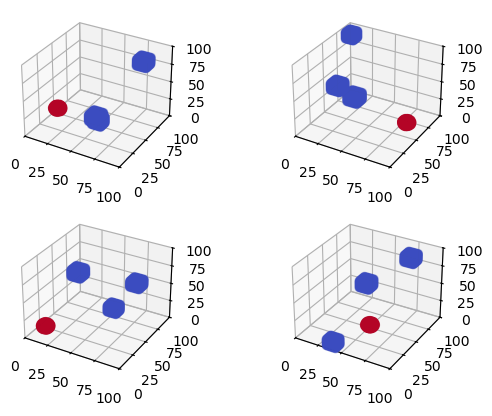

In [7]:
# Visualize the ShapeDataset output
import matplotlib.pyplot as plt


dataloader = torch.utils.data.DataLoader(ShapeDataset(), batch_size=4, collate_fn=VDBTensor.cat)
X = next(iter(dataloader))
# Ground truth
gt = X.feature.jdata[:,-1:]

fig = plt.figure()

for i in range(4):

    # ijks and ground truth for batch element i
    X_ijks_0 = X.grid.ijk.jdata[X.grid.jidx == i].detach().cpu().numpy()
    X_gt_0 = gt[X.grid.jidx == i].detach().cpu().numpy()

    dim = 100
    ax = fig.add_subplot(2,2,i+1, projection="3d")
    ax.set_xlim(0, dim)
    ax.set_ylim(0, dim)
    ax.set_zlim(0, dim)
    ax.scatter3D(X_ijks_0[:, 0], X_ijks_0[:, 1], X_ijks_0[:, 2], marker="o", c=X_gt_0, cmap="coolwarm", alpha=0.25)

fig.show()

##### Convolutional UNet

Here's a simple UNet we'll use to segment the shapes in the 3D volume built from fVDB `SparseConv3d` layers and `LeakyReLU` activations.

In [8]:
# Define model
class ConvClass(SparseConv3d):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, bias=False, transposed=False):
        super(ConvClass, self).__init__(in_channels, out_channels, kernel_size=kernel_size, stride=stride, bias=bias, transposed=transposed)
        self.relu = LeakyReLU()

    def forward(self, x, out_grid=None):
        return self.relu(super(ConvClass, self).forward(x, out_grid=out_grid).type(torch.float))

class UNet(torch.nn.Module):
    def __init__(self, in_ch = 3, out_ch = 1, growth_rate = 16):
        super(UNet, self).__init__()
        depth = 0

        self.conv0_0 = ConvClass(in_ch, growth_rate * 2 ** (depth + 1))
        self.conv0_1 = ConvClass(growth_rate * 2 ** (depth + 1), growth_rate * 2 ** (depth + 1))

        depth += 1
        self.conv1_0 = ConvClass(growth_rate * 2 ** (depth), growth_rate * 2 ** (depth + 1), stride=2)
        self.conv1_1 = ConvClass(growth_rate * 2 ** (depth + 1), growth_rate * 2 ** (depth + 1))

        depth += 1
        self.conv2_0 = ConvClass(growth_rate * 2 ** (depth), growth_rate * 2 ** (depth + 1), stride=2)
        self.conv2_1 = ConvClass(growth_rate * 2 ** (depth + 1), growth_rate * 2 ** (depth + 1))

        depth += 1
        self.conv3_0 = ConvClass(growth_rate * 2 ** (depth), growth_rate * 2 ** (depth + 1), stride=2)
        self.conv3_1 = ConvClass(growth_rate * 2 ** (depth + 1), growth_rate * 2 ** (depth + 1))

        depth += 1
        self.conv4_0 = ConvClass(growth_rate * 2 ** (depth), growth_rate * 2 ** (depth + 1), stride=2)
        self.conv4_1 = ConvClass(growth_rate * 2 ** (depth + 1), growth_rate * 2 ** (depth + 1))

        depth -= 1
        self.dconv3_0 = ConvClass(growth_rate * 2 ** (depth + 2), growth_rate * 2 ** (depth + 1), stride=2, transposed=True)
        self.dconv3_1 = ConvClass(growth_rate * 2 ** (depth + 2), growth_rate * 2 ** (depth + 1))
        self.dconv3_2 = ConvClass(growth_rate * 2 ** (depth + 1), growth_rate * 2 ** (depth + 1))

        depth -= 1
        self.dconv2_0 = ConvClass(growth_rate * 2 ** (depth + 2), growth_rate * 2 ** (depth + 1), stride=2, transposed=True)
        self.dconv2_1 = ConvClass(growth_rate * 2 ** (depth + 2), growth_rate * 2 ** (depth + 1))
        self.dconv2_2 = ConvClass(growth_rate * 2 ** (depth + 1), growth_rate * 2 ** (depth + 1))

        depth -= 1
        self.dconv1_0 = ConvClass(growth_rate * 2 ** (depth + 2), growth_rate * 2 ** (depth + 1), stride=2, transposed=True)
        self.dconv1_1 = ConvClass(growth_rate * 2 ** (depth + 2), growth_rate * 2 ** (depth + 1))
        self.dconv1_2 = ConvClass(growth_rate * 2 ** (depth + 1), growth_rate * 2 ** (depth + 1))

        depth -= 1
        self.dconv0_0 = ConvClass(growth_rate * 2 ** (depth + 2), growth_rate * 2 ** (depth + 1), stride=2, transposed=True)
        self.dconv0_1 = ConvClass(growth_rate * 2 ** (depth + 2), growth_rate * 2 ** (depth + 1))
        self.dconv0_2 = ConvClass(growth_rate * 2 ** (depth + 1), growth_rate * 2 ** (depth + 1))
        self.output = SparseConv3d(growth_rate * 2 ** (depth + 1), out_ch, kernel_size=1, bias=False)

    def forward(self, x):
        x = self.conv0_0(x)
        conv0_output = self.conv0_1(x)

        x = self.conv1_0(conv0_output)
        conv1_output = self.conv1_1(x)

        x = self.conv2_0(conv1_output)
        conv2_output = self.conv2_1(x)

        x = self.conv3_0(x)
        conv3_output = self.conv3_1(x)

        x = self.conv4_0(x)
        x = self.conv4_1(x)

        x = self.dconv3_0(x, out_grid=conv3_output.grid)
        x = VDBTensor.cat([x, conv3_output], dim=1)
        x = self.dconv3_1(x)
        x = self.dconv3_2(x)

        x = self.dconv2_0(x, out_grid=conv2_output.grid)
        x = VDBTensor.cat([x, conv2_output], dim=1)
        x = self.dconv2_1(x)
        x = self.dconv2_2(x)

        x = self.dconv1_0(x, out_grid=conv1_output.grid)
        x = VDBTensor.cat([x, conv1_output], dim=1)
        x = self.dconv1_1(x)
        x = self.dconv1_2(x)

        x = self.dconv0_0(x, out_grid=conv0_output.grid)
        x = VDBTensor.cat([x, conv0_output], dim=1)
        x = self.dconv0_1(x)
        x = self.dconv0_2(x)
        x = self.output(x)
        return x

Let's train this network in a simple training loop and visualize the output of the network.  Each volume has about 5% occupancy of the total volume which, if it were 'dense', would contain one million voxels.  In the 'dense' case, a batch size of 32 would mean we're training on 32 million voxels per batch!

In [11]:
# Train the model!
torch.random.manual_seed(0)
# Data
batch_size = 32

dataset = ShapeDataset()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, collate_fn=VDBTensor.cat)

# Model, Loss, Optimizer
model = UNet(growth_rate = 8).to("cuda")
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 5
with tqdm.tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        for i, vdb_tensor in enumerate(dataloader):
            target = vdb_tensor.feature.jdata[:,-1:]
            X = VDBTensor(vdb_tensor.grid, \
                          # features are all but the last channel which contains the ground truth
                          vdb_tensor.grid.jagged_like(vdb_tensor.feature.jdata[:,:-1].contiguous()))
            optimizer.zero_grad()
            y_hat = model(X)

            l = loss(y_hat.feature.jdata.float(), target)

            l.backward()
            optimizer.step()
            pbar.set_description(f"Epoch {epoch}, batch {i}, loss {l.item()}")
        pbar.update(1)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4, batch 24, loss 0.008950453251600266: 100%|██████████| 5/5 [00:33<00:00,  6.65s/it]


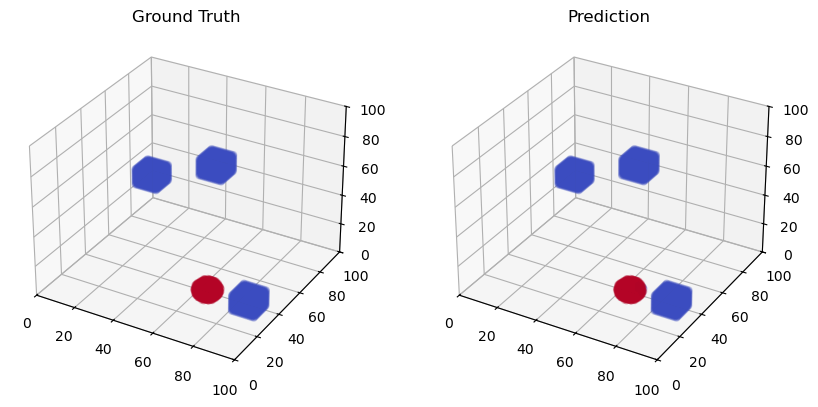

In [12]:
# Visualize the results of the trained network
import matplotlib.pyplot as plt

# Get a batch of data
X = next(iter(dataloader))

# Remove the ground truth channel from the features for the model input
input = VDBTensor(X.grid, X.grid.jagged_like(X.feature.jdata[:,:-1].contiguous()))
# Ground truth
gt = X.feature.jdata[:,-1:]

fig = plt.figure(figsize=(10, 20))

# ijks and ground truth for batch element 0
X_ijks_0 = X.grid.ijk.jdata[X.grid.jidx == 0].detach().cpu().numpy()
X_gt_0 = gt[X.grid.jidx == 0].detach().cpu().numpy()


# plot input and ground truth values
dim = 100
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.set_xlim(0, dim)
ax.set_ylim(0, dim)
ax.set_zlim(0, dim)
ax.scatter3D(X_ijks_0[:, 0], X_ijks_0[:, 1], X_ijks_0[:, 2], marker="o", c=X_gt_0, cmap="coolwarm", alpha=0.25)
ax.set_title("Ground Truth")


# model inference
model.eval()
sigmoid = Sigmoid()
pred = sigmoid(model(input))

# predicted values for batch element 0
pred_0 = np.round(pred.feature.jdata[pred.grid.jidx == 0].detach().cpu().numpy())

ax = fig.add_subplot(1, 2, 2, projection="3d")
ax.set_xlim(0, dim)
ax.set_ylim(0, dim)
ax.set_zlim(0, dim)
ax.scatter3D(X_ijks_0[:, 0], X_ijks_0[:, 1], X_ijks_0[:, 2], marker="o", c=pred_0, cmap="coolwarm", alpha=0.25)
ax.set_title("Prediction")

fig.show()